In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### NB: ---Nous avons constaté qu'avec la recherche par grille tout comme aléatoire, le score pour l'ensemble des données d'entrainement, est presque parfait quelque soit la métrique que nous choisissons pour le modèle KNeighborsClassifier. Raison pour laquelle nous avons décidé de  comparer nos différents modèles sur le best score retournés par la recherche aléatoire /grille, car celui n'est pas affecté par ce problème. Ce pourrait être un bug lié à scikit learn et notre environnement de travail, car d'autres étudiants n'ont pas eu ce problème (Nous travaillons avec l'image docker du cours et avec docker desktop). Nous examinerons d'avantage ce problème plus tard ---

# Bibilothèques

In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.utils.fixes import loguniform
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [56]:
# fonction pour afficher plusieurs courbe ROC sur une même figure
def plot_roc_curve(y_train, results):
    plt.figure().clear()
    for key in results:
        fpr, tpr, thresholds = roc_curve(y_train, results[key], drop_intermediate=False)
        auc = roc_auc_score(y_train, results[key])
        plt.plot(fpr, tpr, label = key +', auc = '+str(auc))
    plt.legend(loc=4)        

In [191]:
# fonction pour afficher plusieurs diagrammes à baton afin de comparer visuellement les scores log loss
def addlabels(x,y):
    for key in results:
        plt.text(key, results[key], round(results[key],2), ha = 'center')

def plot_log_loss_bar(results):
    x = np.arange(len(results))
    plt.bar(results.keys(), results.values(), width=0.1)
    plt.xticks(rotation=45)
    plt.ylabel('Log los')
    plt.title('Score log loss pour chaque modèle')
    plt.xlabel('Modèles')
    addlabels(results.keys(),results.values())
    plt.show()

# Lecture et exploration des données

In [4]:
donnees = pd.read_csv('../../data/chansons.csv')

In [5]:
# Tailles du jeux de données
donnees.shape

(7574, 39)

In [6]:
# Affichages des 10 premières lignes de données pour en avoir une idée
donnees.head(10)

,annee,titre,artiste,chansonID,artisteID,signature_temp,signature_temp_confiance,intensite,tempo,tempo_confiance,...,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,...,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,...,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,...,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,...,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,...,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0
5,2010,Better Off This Way,A Day to Remember,SOCEYON1315CD4A23E,AROBSHL1187B9AFB01,4,1.000,-3.807,160.366,0.347,...,91.117,-54.378,53.808,-33.183,54.657,-64.478,34.522,-40.922,36.453,0
6,2010,All Signs Point to Lauderdale,A Day to Remember,SODZEHH1377566C93F,AROBSHL1187B9AFB01,4,0.968,-4.114,149.967,0.273,...,97.938,-57.289,34.989,-35.724,72.925,-66.070,75.881,-51.232,28.741,0
7,2010,Out of Time,A Day to Remember,SOJQXRI12C5664F058,AROBSHL1187B9AFB01,4,0.861,-3.683,160.328,0.830,...,114.817,-56.108,25.915,-69.726,112.780,-117.207,27.494,-50.713,31.470,0
8,2010,If I Leave,A Day to Remember,SOWCXMH137733DA46E,AROBSHL1187B9AFB01,4,0.622,-4.967,155.112,0.018,...,67.466,-53.234,40.445,-33.081,50.643,-61.121,50.245,-53.695,26.625,0
9,2010,Whataya Want From Me,Adam Lambert,SOFOBLL13A9E22142F,ARIGTAO11FED0C4411,4,0.938,-15.557,95.904,0.929,...,99.150,-69.346,56.233,-94.733,62.789,-102.870,65.328,-48.411,47.376,1


In [7]:
# Statistiques descriptives des colonnees numériques du jeu de données
donnees.describe()

,annee,signature_temp,signature_temp_confiance,intensite,tempo,tempo_confiance,gamme,gamme_confiance,energie,hauteur,...,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,...,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000
mean,2001.455902,3.893979,0.853307,-8.817262,107.348267,0.622866,5.384605,0.433843,0.675471,0.010817,...,95.653221,-63.703984,50.057489,-59.515016,68.028067,-87.340055,55.520722,-50.868457,47.490774,0.147742
std,5.815223,0.532561,0.243748,4.377079,24.665030,0.304656,3.572579,0.273826,0.243473,0.013671,...,26.859726,15.970244,14.463524,17.190527,20.381321,30.464274,23.549473,11.701530,12.463966,0.354868
min,1990.000000,0.000000,0.000000,-42.451000,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,...,15.699000,-158.756000,-25.955000,-149.507000,8.415000,-208.819000,-6.359000,-145.599000,7.200000,0.000000
25%,1997.000000,4.000000,0.819250,-10.847000,88.860250,0.372000,2.000000,0.204000,0.500138,0.003000,...,76.498000,-73.050750,40.584500,-70.282500,53.037250,-105.130250,39.196000,-58.058000,38.975250,0.000000
50%,2002.000000,4.000000,0.979000,-7.649000,103.268000,0.701500,6.000000,0.451500,0.718160,0.007000,...,94.632500,-62.661500,49.220000,-58.650000,65.935000,-83.074000,50.895000,-50.892500,46.437500,0.000000
75%,2006.000000,4.000000,1.000000,-5.640000,124.800500,0.892000,9.000000,0.646000,0.887396,0.014000,...,112.708250,-52.982750,58.462000,-47.699750,81.267000,-64.518000,66.593000,-43.292250,55.030250,0.000000
max,2010.000000,7.000000,1.000000,1.305000,244.307000,1.000000,11.000000,1.000000,0.998492,0.541000,...,214.819000,-2.382000,144.985000,1.140000,161.518000,-10.640000,192.417000,-6.497000,110.272000,1.000000


In [8]:
# Statistiques descriptives des colonnes catégoriques
donnees.describe(exclude='number')

,titre,artiste,chansonID,artisteID
count,7574,7574,7574,7574
unique,7141,1032,7549,1047
top,Intro,Various artists,SOKLHIK131343A2E06,ARAGWS81187FB3F768
freq,15,162,2,222


In [9]:
# NB: Nous n'observons aucune valeur manquante au regard des statistiques précédentes

In [10]:
#g = sns.PairGrid(donnees.select_dtypes(include='number'))
#g = g.map(sns.scatterplot)

# Préparation des données

In [11]:
# Au regard du nombre très élévé de valeurs possibles pour les variables catégoriques (titre, artiste, chansonID et artisteID),
# nous allons nous passer de ces variables dans nos modèles pour éviter le fleaux de la dimension.
donnees_numerique = donnees.select_dtypes(exclude='object')
#donnees_numerique

In [12]:
# Variables explicatives et variable expliquée
X = donnees_numerique.drop('Top10', axis=1)
y = donnees_numerique['Top10']

In [13]:
# Normalisation des variables explicatives: malgré la différence d'échelle qui n'est pas significative entre les valeurs,
# nous allons normaliser nos variables explicatives
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Séparation des données en Train-Test

In [71]:
# Observation sur le débalancement des classes: Proportition de la classe positive(1) vs classe négative(0)
prop_classe_positive = y.sum() / len(y)
print(f'Proportition de la classe positive = {prop_classe_positive}')

Proportition de la classe positive = 0.14774227620808028


In [75]:
# Vu le debalancement observé, nous allons, pour toute validation croisée utiliser une validation sur 5 plis strafiés, lorsque 
# le classificateur ne le fournit pas, définis comme suit
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=2023, shuffle=True, test_size=0.3)

# Modélisation
Pour chacun des modèles (sauf le baseline), nous allons utiliser la recherche aléatoire pour trouver les meilleurs hyperparametres.

## Modèle baseline

In [72]:
baseline_cf = DummyClassifier(strategy='most_frequent')
baseline_cf.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [184]:
# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
results = {}
y_pred_proba_baseline = baseline_cf.predict_proba(X_train)[:,1]
#results['Baseline'] = y_pred_proba_baseline

#plot_roc_curve(y_train, results)

loss_baseline = log_loss(y_train, y_pred_proba_baseline)
results['Baseline'] = loss_baseline
print(f'Log loss Baseline = {loss_baseline}')

Log loss Baseline = 5.323935220463824


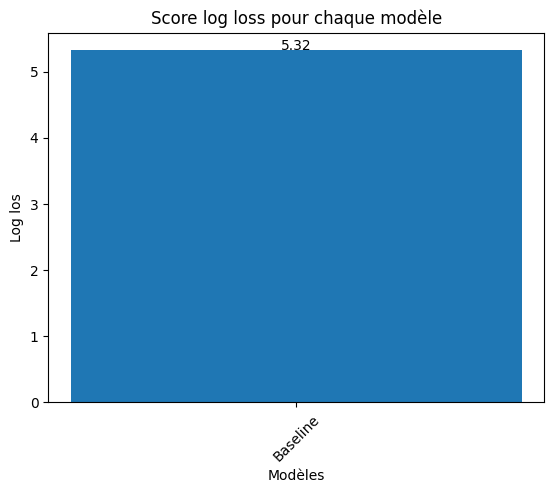

In [192]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## Regression logistique avec recherche aléatoire des meilleurs hyperparamètres

In [193]:
# Estimateur
lg_reg = LogisticRegression(penalty='elasticnet', solver='saga', n_jobs=-1, max_iter=10000, random_state=2023)

In [194]:
# Parametre grille
#param_grid = {'C': [1e-2, 1e-1, 0.3, 1e-0, 10, 76, 100], 'l1_ratio' : [0, 0.5, 1]}

# Recherche grille
#log_reg_grid_search = GridSearchCV(lg_reg, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# fit grille
#log_reg_grid_search.fit(X_train, y_train)

#print(f'Le meilleur score grille est (auc moyen) : {log_reg_grid_search.best_score_}')
#print(f'Les meilleurs paramètres grille sont: {log_reg_grid_search.best_params_}')

# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
#y_train_pred_proba_lg_reg = log_reg_grid_search.best_estimator_.predict_proba(X_train)[:,1]
#results['Regression logistique grille'] = y_train_pred_proba_lg_reg

#plot_roc_curve(y_train, results)

In [195]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(C = loguniform(1e-20, 1e2), l1_ratio = loguniform(10e-10,1))

# Recherche aléatoire: Nous précisons la valeur de cv pour avoir une validation croisée stratifiées à 5 plis
log_reg_rnd_search = RandomizedSearchCV(lg_reg, 
                                        param_rnd_search, 
                                        n_iter=100, 
                                        scoring='neg_log_loss', 
                                        cv=5, 
                                        verbose=1, 
                                        n_jobs=-1,
                                        random_state=2023)

In [196]:
# fit 
log_reg_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                                penalty='elasticnet',
                                                random_state=2023,
                                                solver='saga'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fee6c113df0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fee6c12c790>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [198]:
results['Regression logistique'] = -log_reg_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-log_reg_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {log_reg_rnd_search.best_params_}')

Le meilleur score est (log loss moyen) : 0.330649832069264
Les meilleurs paramètres sont: {'C': 0.6193889824323069, 'l1_ratio': 0.2996004362847121}


In [201]:
# Score sur l'ensemble des données d'entrainement
#y_train_pred_proba_lg_reg_rnd = log_reg_rnd_search.best_estimator_.predict_proba(X_train)[:,1]
#results['Regression logistique'] = y_train_pred_proba_lg_reg_rnd

#plot_roc_curve(y_train, results)

#loss_log_reg = log_loss(y_train, y_train_pred_proba_lg_reg_rnd)
#results['Regression logistique'] = loss_log_reg
#print(f'Log loss Regression Logistique = {loss_log_reg}')

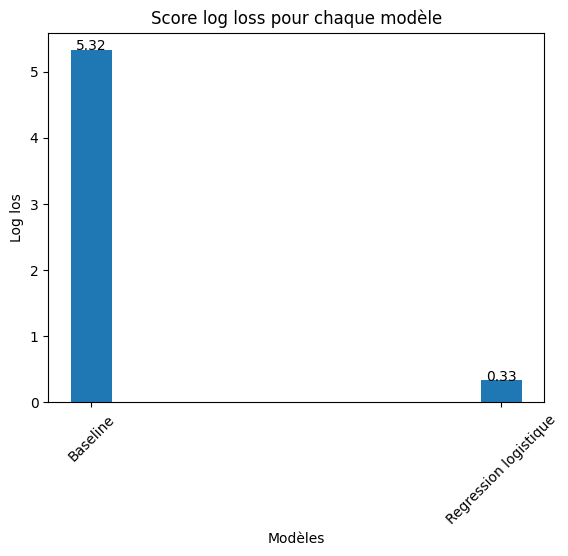

In [199]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## K plus proches voisin avec recherche aléatoire des meilleurs hyperparamètres

In [203]:
# Estimateur
knn_cf = KNeighborsClassifier(n_jobs=-1)

In [206]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(n_neighbors = randint(2, 50), weights = ['uniform', 'distance'])

# Recherche aléatoire
knn_rnd_search = RandomizedSearchCV(knn_cf, 
                                    param_rnd_search, 
                                    n_iter=100, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [207]:
# fit 
knn_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fee6c2463b0>,
                                        'weights': ['uniform', 'distance']},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [208]:
results['KNN'] = -knn_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-knn_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {knn_rnd_search.best_params_}')

Le meilleur score est (log loss moyen) : 0.34463107922334013
Les meilleurs paramètres sont: {'n_neighbors': 45, 'weights': 'distance'}


In [209]:
# Score sur l'ensemble des données d'entrainement: Courbe ROC et AUC
#y_train_pred_proba_knn_rnd = knn_rnd_search.best_estimator_.predict_proba(X_train)[:,1]
#results['K voisins'] = y_train_pred_proba_knn_rnd

#plot_roc_curve(y_train, results)

#loss_log_knn = log_loss(y_train, y_train_pred_proba_knn_rnd)
#results['KNN'] = loss_log_knn
#print(f'Log loss knn = {loss_log_knn}')

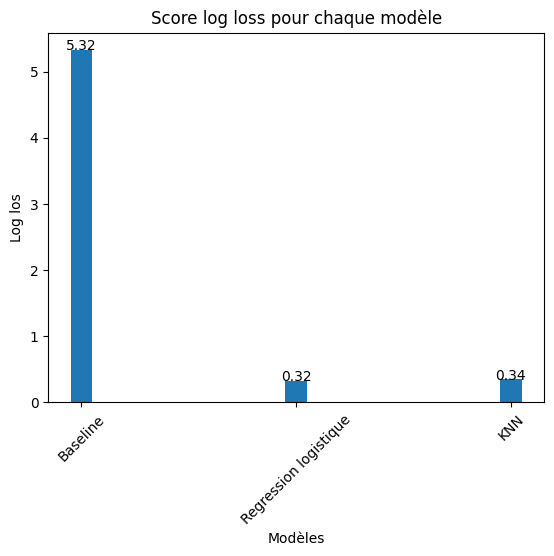

In [210]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## Arbre de décision

In [213]:
# Estimateur
dt_cf = DecisionTreeClassifier(random_state=2023)

In [232]:
# Paramètres de la recherche aléatoire
param_rnd_search = dict(ccp_alpha = loguniform(1e-3, 1e3),
                        criterion=['gini','entropy','log_loss'],
                        max_depth=randint(2, 35))

# Recherche aléatoire
dt_rnd_search = RandomizedSearchCV(dt_cf, 
                                    param_rnd_search, 
                                    n_iter=100, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1,
                                    random_state=2023)

In [233]:
# fit 
dt_rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fef33ed3f10>,
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fee2c7c6c50>},
                   random_state=2023, scoring='neg_log_loss', verbose=1)

In [234]:
results['Decision Tree'] = -dt_rnd_search.best_score_
print(f'Le meilleur score est (log loss moyen) : {-dt_rnd_search.best_score_}')
print(f'Les meilleurs paramètres sont: {dt_rnd_search.best_params_}')

Le meilleur score est (log loss moyen) : 0.37529387182936513
Les meilleurs paramètres sont: {'ccp_alpha': 0.0019705610514033317, 'criterion': 'gini', 'max_depth': 8}


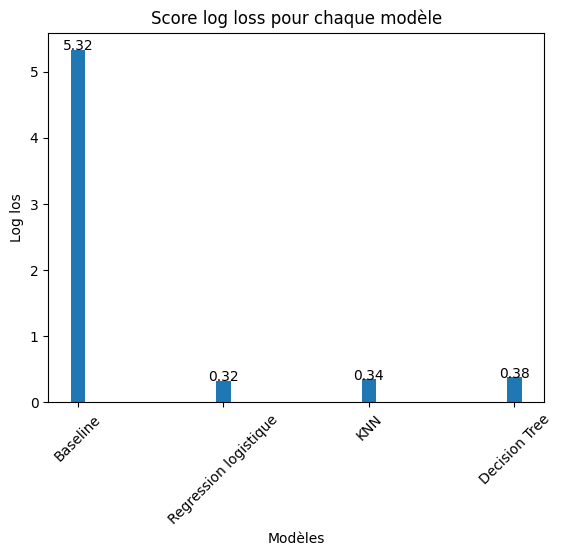

In [235]:
# Comparaison visuelle des log loss sur un digramme à bar
plot_log_loss_bar(results)

## Forêt aléatoire

In [ ]:
- choix des meilleurs hyperparamètres,
- bagging, 
- boosting